In [76]:
# importing packages and modules
import pandas as pd 
import numpy as np
from pathlib import Path
import math
import pickle
import matplotlib.pyplot as plt
import scipy.stats as stats


In [77]:
trueP = np.zeros((2,2))
trueP[0,0]=0.97
trueP[0,1]=0.03
trueP[1,0]=.05
trueP[1,1]=.95
print("True Transition Matrix P")
print(trueP)

True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]


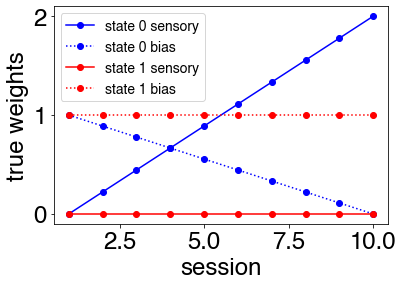

Session indicies
[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]


In [78]:
S = 10 # sessions
T = 500 # trials per session
N = T * S
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
plt.plot(range(1,S+1),ourW[:,0,1],color='blue',marker='o',label='state 0 sensory')
plt.plot(range(1,S+1),ourW[:,0,0],color='blue',marker='o',linestyle=':',label='state 0 bias')
plt.plot(range(1,S+1),ourW[:,1,1],color='red',marker='o',label='state 1 sensory')
plt.plot(range(1,S+1),ourW[:,1,0],color='red',marker='o',linestyle=':',label='state 1 bias')
plt.ylabel("true weights")
plt.xlabel('session')
plt.legend(fontsize='xx-small')
plt.show()
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,0] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)



In [79]:
def emission_probability(x, w,  z=None, latents=False):
    '''
    Calculating emission probabilities for each session

    Parameters
    ----------
    x: N x D numpy array
    z: N x 1 numpy array
    w: N x K x D x C numpy array

    Returns
    -------
    phi: N x K x C numpy array
        emission probabilities
    '''
    N = x.shape[0]
    D = x.shape[1]
    K = w.shape[1]
    phi = np.empty((N,K,C)) # probability that it is state 1
    for k in range(0,K):
        for c in range(0,C):
            phi[:,k,c] = np.exp(-np.sum(w[:,k,:,c]*x,axis=1))
        phi[:,k,:]  = np.divide((phi[:,k,:]).T,np.sum(phi[:,k,:],axis=1)).T     

    return phi

# CHECKING WITH IRIS' CODE

In [94]:
def simulate_data(trueW, trueP,priorZstart,sessInd):
    '''
    function that simulates X and Y data from true weights and true transition matrix
    S sessions, K states, D features (in the order: bias, sensory)
    K = 2 BINOMIAL

    Parameters
    ----------
    trueW: S x K x D numpy array
        true weight matrix
    trueP: K X K numpy array
        true probability transition matrix
    priorZstart: int
        prior for initial latent state to be 0
    sessInd: list of int
        indices of each session start, together with last session end
        
    Returns
    -------
    x_sim: N x D
    y_sim: N x C
    z_sim: 

    '''

    # check that weights and transition matrix are valid options

    n = trueW.shape[0]
    k = trueW.shape[1] # states
    d = trueW.shape[2] # features
    c = trueW.shape[3]
    x = np.empty((n,d))
    y = np.zeros((n,c)).astype(int)
    z = np.empty((n,),dtype=int)

    # input data x
    x[:,0] = 1 # bias term
    x[:,1] = stats.uniform.rvs(loc=-16,scale=33,size=n).astype(int)
    # standardizing sensory info
    x[:,1] = x[:,1] - x[:,1].mean()
    x[:,1] = x[:,1] / x[:,1].std()

    # latent variables z 
    for t in range(0,n):
        if (t in sessInd[:-1]): # beginning of session has a new draw for latent
            z[t] = np.random.binomial(n=1,p=1-priorZstart)
        else:
            z[t] = np.random.binomial(n=1, p=trueP[z[t-1],1])
    
    phi = emission_probability(x, trueW,  z=None, latents=False)

    for t in range(0,n):
        y[t,int(np.random.binomial(n=1,p=phi[t,z[t],1]))]=1

    return x, y, z

xSim, ySim, zSim  = simulate_data(trueW=trueW, trueP=trueP, priorZstart=0.5, sessInd=sessInd)

In [139]:
def reshapeObs(y):
    yNew = np.empty((y.shape[0],))
    if(y.shape[1] > 1):
        yNew = np.array(np.where(y==1)[1]).reshape(y.shape[0],)
    return yNew
reshapeObs(ySim)



array([1, 1, 0, ..., 0, 1, 0])

In [140]:
print(ySim)

[[0 1]
 [0 1]
 [1 0]
 ...
 [1 0]
 [0 1]
 [1 0]]


In [85]:
phiSim = emission_probability(xSim, trueW,  z=None, latents=False)
print(phiSim[:,1,:])
print(xSim[0,:])
print(trueW[0,0,:,:])

[[0.26894142 0.73105858]
 [0.26894142 0.73105858]
 [0.26894142 0.73105858]
 ...
 [0.26894142 0.73105858]
 [0.26894142 0.73105858]
 [0.26894142 0.73105858]]
[ 1.         -1.67712912]
[[1. 0.]
 [0. 0.]]


In [84]:
# Using Iris' code to fit simulate data and calculate alpha forward and backward

# Import outside packages by changing the path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'glmhmm')))
from glmhmm import glm, glm_hmm, utils
from glmhmm.utils import permute_states, find_best_fit, compare_top_weights
from glmhmm import visualize, analysis

true_GLMHMM = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli")
# # compute phi for each state from weights 
phi = np.zeros((true_GLMHMM.n,true_GLMHMM.k,true_GLMHMM.c))
for i in range(true_GLMHMM.n):
    for zi in range(true_GLMHMM.k):
        phi[i,zi,:] = true_GLMHMM.glm.observations.compObs(xSim[i,:],trueW[i,zi,:,:])
print("Observation prob NxKxC")
print(phi[:,1,:])

# inits = 1 # set the number of initializations

# # store values for each initialization
# lls_all = np.zeros((inits,250))
# A_all = np.zeros((inits,K,K))
# w_all = np.zeros((inits,K,D,C))

# fit the model for each initialization
# A_init,w_init,pi_init = true_GLMHMM.generate_params() # initialize the model parameters
# lls_all[0,:],A_all[0,:,:],w_all[0,:,:],pi0 = true_GLMHMM.fit(ySim,xSim,A_init,w_init,maxiter=1,sess=sessInd) # fit the model



Observation prob NxKxC
[[0.73105858 0.26894142]
 [0.73105858 0.26894142]
 [0.73105858 0.26894142]
 ...
 [0.73105858 0.26894142]
 [0.73105858 0.26894142]
 [0.73105858 0.26894142]]


In [11]:
def accuracy(x,y,z,s):
    '''
    Calculates and plots percentage accuracy (given X and Y) and percentage accuracy in state 0 (given Z)

    X: N x D numpy array
    Y: N x 1 numpy array
    s: int
        number of sessions
    '''
    n = x.shape[0]
    perf = np.zeros((s,))
    trials = int(n/s)
    state0 = np.empty((s,))
    ind = []
    for sess in range(0,s):
        state0[sess] = trials - z[sess*trials:(sess+1)*trials].sum()
        for t in range(0,trials):
            if (x[sess*trials+t,0]>0 and y[sess*trials+t]==1):
                perf[sess]+=1
            elif (x[sess*trials+t,0]<0 and y[sess*trials+t]==0):
                perf[sess]+=1
            else:
                ind.append(sess*trials+t)

    perf = perf / trials # normalize to number of trials per session
    state0 = state0 / trials
    plt.plot(range(0,s),state0,marker='o',color='darkgray',label='state 0')
    plt.plot(range(0,s),perf,marker='o',label="accurracy")
    plt.xlabel("sesion")
    plt.legend()
    plt.show()

    return perf, ind
perf,ind = accuracy(xSim,ySim,zSim,s=10)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [163]:
# already checked with Iris' function that it is correct
def forward_pass(y,P,phi,pi0=None):
    '''
    Calculates alpha scaled as part of the forward-backward algorithm in E-step for a single session 
    given current parameters weight w and transition matrix P

    Parameters
    ----------
    y : TxC vector of observations
    P : KxK matrix of transition probabilities
    phi : TxKxC matrix of emission probabilities
        
    Returns
    -------
    ll : float, marginal log-likelihood of the data p(y)
    alpha : nx1 vector of the conditional probabilities p(z_t|x_{1:t},y_{1:t})
    ct : nx1 vector of the forward marginal likelihoods p(y_t | y_1:t-1)
    '''
    T = y.shape[0]
    K = P.shape[0]
    
    alpha = np.zeros((T,K)) # forward probabilities p(z_t | y_1:t)
    alpha_prior = np.zeros((T,K)) # prior probabilities p(z_t | y_1:t-1)
    lt = np.zeros((T,K)) # likelihood of data p(y_t|z_t)
    ct = np.zeros(T) # forward marginal likelihoods p(y_t | y_1:t-1)
    y = reshapeObs(y)

    # forward pass calculations
    for t in range(0,T):
        lt[t,:] = phi[t,:,y[t]] # likelihood p(y_t | z_t)
        if (t==0): # time point 0
            if (pi0==None):
                alpha_prior[0,:] = np.ones((1,K))/K # prior of z_0 before any data (=uniform)
            else:
                alpha_prior[0,:] = pi0
        else:
            alpha_prior[t,:] = (alpha[t-1,:].T @ P) # conditional p(z_t | y_1:t-1)
        pxz = np.multiply(lt[t],alpha_prior[t,:]) # joint P(y_1:t,z_t)
        ct[t] = np.sum(pxz) # conditional p(y_t | y_1:t-1)
        alpha[t,:] = pxz/ct[t] # conditional p(z_t | y_1:t)
    
    return alpha,alpha_prior,ct

alpha,alpha_prior,ct = forward_pass(ySim[2000:2500,:],trueP,phiSim[2000:2500,:,:])




In [168]:
# already checked with Iris' function that it is correct
def backward_pass(y,P,phi,ct,pi0=None):
    '''
    Calculates beta scaled as part of the forward-backward algorithm in E-step for a single session 
    given current parameters weight w and transition matrix P

    Parameters
    ----------
    y : TxC vector of observations
    P : KxK matrix of transition probabilities
    phi : TxKxC matrix of emission probabilities
    ct : Tx1 numpy vector of forward marginal likelihoods p(y_t | y_1:t-1), calculated at forward_pass
        
    Returns
    -------
    beta: TxK numpy array 
    
    '''
    T = y.shape[0]
    K = P.shape[0]
    y = reshapeObs(y)
    
    beta = np.zeros((T,K)) # backward conditional probabilities p(y_t+1:T | z_t)/p(y_t+1:T | y_1:t)
    lt = np.zeros((T,K)) # likelihood of data p(y_t|z_t)

    # last time point
    beta[-1] = 1 # p(z_T=1)

    # backward pass calculations
    for t in np.arange(T-2,-1,-1):
        lt[t+1,:] = phi[t+1,:,y[t+1]] 
        beta[t,:] = P @ (np.multiply(beta[t+1,:],lt[t+1,:]))
        beta[t,:] = beta[t,:] / ct[t+1] # scaling factor
    
    return beta
backward_pass(ySim[2000:2500,:],trueP,phiSim[2000:2500,:,:],ct)

array([[0.25012458, 1.46750168],
       [0.41052785, 1.1536133 ],
       [0.23307138, 1.50722592],
       [0.17638839, 1.67920724],
       [0.22563019, 1.27629972],
       [0.16981734, 1.40702582],
       [0.23535924, 1.18405272],
       [0.34233641, 1.10390779],
       [0.15971931, 1.45031353],
       [0.18233585, 1.25729886],
       [0.30246845, 1.10568175],
       [0.56061775, 1.04044653],
       [0.33056771, 1.17824882],
       [0.45686255, 1.10455363],
       [0.46561026, 1.12192891],
       [0.57131208, 1.08890514],
       [0.48010769, 1.16438353],
       [0.2526597 , 1.72104455],
       [0.23077365, 1.61736694],
       [0.3279902 , 1.23614591],
       [0.46127881, 1.12398144],
       [0.56541953, 1.09073088],
       [0.60114707, 1.09388217],
       [0.54431672, 1.14561026],
       [0.59053586, 1.13099784],
       [0.58235376, 1.15334926],
       [0.7952415 , 1.05462486],
       [0.65114551, 1.14563906],
       [0.44057379, 1.48159018],
       [0.43261232, 1.4587022 ],
       [0.

In [166]:
ll_s,alpha_s,alpha_prior_s,cs_s = true_GLMHMM.forwardPass(reshapeObs(ySim[2000:2500,:]),trueP,phiSim[2000:2500,:,:])
pBack_s,beta_s,zhatBack_s = true_GLMHMM.backwardPass(reshapeObs(ySim[2000:2500,:]),trueP,phiSim[2000:2500,:,:],alpha_s,cs_s)
print(beta_s)

[[0.25012458 1.46750168]
 [0.41052785 1.1536133 ]
 [0.23307138 1.50722592]
 [0.17638839 1.67920724]
 [0.22563019 1.27629972]
 [0.16981734 1.40702582]
 [0.23535924 1.18405272]
 [0.34233641 1.10390779]
 [0.15971931 1.45031353]
 [0.18233585 1.25729886]
 [0.30246845 1.10568175]
 [0.56061775 1.04044653]
 [0.33056771 1.17824882]
 [0.45686255 1.10455363]
 [0.46561026 1.12192891]
 [0.57131208 1.08890514]
 [0.48010769 1.16438353]
 [0.2526597  1.72104455]
 [0.23077365 1.61736694]
 [0.3279902  1.23614591]
 [0.46127881 1.12398144]
 [0.56541953 1.09073088]
 [0.60114707 1.09388217]
 [0.54431672 1.14561026]
 [0.59053586 1.13099784]
 [0.58235376 1.15334926]
 [0.7952415  1.05462486]
 [0.65114551 1.14563906]
 [0.44057379 1.48159018]
 [0.43261232 1.4587022 ]
 [0.37004442 1.62383904]
 [0.34349847 1.62213354]
 [0.40364298 1.35338052]
 [0.34853718 1.47074952]
 [0.2493624  1.90029845]
 [0.22775655 1.69487043]
 [0.19489766 1.65447812]
 [0.23107597 1.32151004]
 [0.24431189 1.26152168]
 [0.24952505 1.24019107]


In [ ]:
def fit(y,x,P_init,w_init,pi0=None,maxiter=250,tol=1e-3,sess=None):
    '''
    Fitting function based on EM algorithm

    Parameters
    ----------
    y : NxC vector of observations 
    P_init : KxK numpy array
        initial matrix of transition probabilities
    W_init: NxKxDxC numpy array
        initial weight matrix
    pi0 : initial kx1 vector of state probabilities for t=1.
    maxiter : int
         The maximum number of iterations of EM to allow. The default is 250.
    tol : float
        The tolerance value for the loglikelihood to allow early stopping of EM. The default is 1e-3.
    sessions : an optional vector of the first and last indices of different sessions in the data (for separate computations of the E step; first and last entries should be 0 and n, respectively)  
    Returns
    -------
    '''

In [ ]:
# Iris' fitting function

def fit(self,y,x,A,w,pi0=None,fit_init_states=False,maxiter=250,tol=1e-3,sess=None,B=1):
        '''
        Parameters
        ----------
        y : nx1 vector of observations 
        A : initial kxk matrix of transition probabilities
        phi : initial kxc or nxkxc matrix of emission probabilities
        pi0 : initial kx1 vector of state probabilities for t=1.
        fit_init_states : boolean, determines if EM will including fitting pi
        maxiter : int. The maximum number of iterations of EM to allow. The default is 250.
        tol : float. The tolerance value for the loglikelihood to allow early stopping of EM. The default is 1e-3.
        sessions : an optional vector of the first and last indices of different sessions in the data (for
        separate computations of the E step; first and last entries should be 0 and n, respectively)  
        B : an optional temperature parameter used when fitting via direct annealing EM (DAEM; see Ueda and Nakano 1998)                                                                                         
        Returns
        -------
        lls : vector of loglikelihoods for each step of EM, size maxiter 
        A : fitted kxk matrix of transition probabilities
        w : fitted kxdxc omatrix of weights
        pi0 : fitted kx1 vector of state probabilities for t= (only different from initial value of fit_init_states=True)
        '''
        
        self.lls = np.empty(maxiter)
        self.lls[:] = np.nan
            
        # store variables
        self.pi0 = pi0
        
        # # compute phi for each state from weights 
        phi = np.zeros((self.n,self.k,self.c))
        for i in range(self.n):
            for zi in range(self.k):
                phi[i,zi,:] = self.glm.observations.compObs(x[i,:],w[zi,:,:])
        
        if sess is None:
            sess = np.array([0,self.n]) # equivalent to saying the entire data set has one session
        
        for n in range(maxiter):
            
            # E STEP
            alpha = np.zeros((self.n,self.k))
            beta = np.zeros_like(alpha)
            cs = np.zeros((self.n))
            self.pStates = np.zeros_like(alpha)
            self.states = np.zeros_like(cs)
            ll = 0
            
            for s in range(len(sess)-1): # compute E step separately over each session or day of data 
                ll_s,alpha_s,_,cs_s = self.forwardPass(y[sess[s]:sess[s+1]],A,phi[sess[s]:sess[s+1],:,:],pi0=pi0)
                pBack_s,beta_s,zhatBack_s = self.backwardPass(y[sess[s]:sess[s+1]],A,phi[sess[s]:sess[s+1],:,:],alpha_s,cs_s)
                
                
                ll += ll_s
                alpha[sess[s]:sess[s+1]] = alpha_s
                cs[sess[s]:sess[s+1]] = cs_s
                self.pStates[sess[s]:sess[s+1]] = pBack_s ** B
                beta[sess[s]:sess[s+1]] = beta_s
                self.states[sess[s]:sess[s+1]] = zhatBack_s
                
            
            self.lls[n] = ll
            
            # M STEP
            A,w,phi,pi0 = self._updateParams(y,x,self.pStates,beta,alpha,cs,A,phi,w,fit_init_states = fit_init_states)
            
            
            # CHECK FOR CONVERGENCE    
            self.lls[n] = ll
            if  n > 5 and self.lls[n-5] + tol >= ll: # break early if tolerance is reached
                break
        
        self.A,self.w,self.phi,self.pi0 = A,w,phi,pi0

        return self.lls,self.A,self.w,self.pi0